# Sandbox for RNN

In [1]:
# imports here

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
%load_ext tensorboard
from sklearn.metrics import classification_report
import pandas as pd
import time
import numpy as np
import os
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
if IS_COLAB:
    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


/Users/htahir/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


/Users/htahir/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


## Simple RNN on a Generated Time Series for Regression

In [15]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [16]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [678]:
X_valid.shape, X_valid.shape


((2000, 50, 1), (2000, 50, 1))

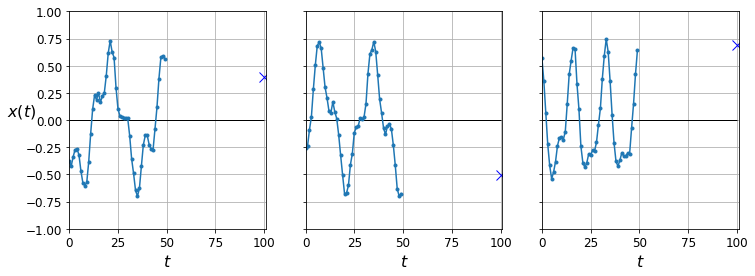

In [677]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [303]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [23]:
X_valid[1, :,0]

array([-0.2529655 , -0.24267727, -0.08966523,  0.03061226,  0.2830733 ,
        0.5034291 ,  0.68315464,  0.71714944,  0.66348517,  0.48309696,
        0.30284724,  0.2052048 ,  0.08450623,  0.06641599,  0.1681185 ,
        0.07499525,  0.0133126 , -0.13783354, -0.32550123, -0.5050951 ,
       -0.67722857, -0.6717539 , -0.6011696 , -0.41138572, -0.30830762,
       -0.11499406, -0.06724501, -0.05520922,  0.01836902,  0.00735723,
        0.02836169,  0.15125608,  0.42631206,  0.6072168 ,  0.64625293,
        0.7213324 ,  0.627726  ,  0.41340816,  0.19029261,  0.06508268,
       -0.0734548 , -0.13179466, -0.05701557, -0.03560268, -0.08019745,
       -0.22776155, -0.41371432, -0.62975067, -0.7007588 , -0.6759614 ],
      dtype=float32)

In [11]:
callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_last_time_step_mse', factor=0.5, patience=2, min_lr=0.00001)
]

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [31]:
y_pred.shape

(2000, 1)

In [27]:
X_valid.shape

(2000, 50, 1)

In [963]:
# build simple RNN model

ffwd_model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[50,1], name='input'),
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1], name='input'),
#     keras.layers.Dense(32, activation='relu', name='hidden_1'),
#     keras.layers.Dense(32, activation='relu', name='hidden_2'),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.Dense(1, name='output')
])
ffwd_model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (SimpleRNN)            (None, None, 20)          440       
_________________________________________________________________
simple_rnn_32 (SimpleRNN)    (None, None, 32)          1696      
_________________________________________________________________
output (Dense)               (None, None, 1)           33        
Total params: 2,169
Trainable params: 2,169
Non-trainable params: 0
_________________________________________________________________


In [55]:
ffwd_model.compile(loss='mse', optimizer='adam')
history = ffwd_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.1548 - val_loss: 0.1505
Epoch 2/20
7000/7000 [==============================] - 7s 966us/sample - loss: 0.1418 - val_loss: 0.1390
Epoch 3/20
7000/7000 [==============================] - 7s 966us/sample - loss: 0.1273 - val_loss: 0.1192
Epoch 4/20
7000/7000 [==============================] - 7s 986us/sample - loss: 0.1070 - val_loss: 0.1004
Epoch 5/20
7000/7000 [==============================] - 7s 963us/sample - loss: 0.0960 - val_loss: 0.0943
Epoch 6/20
7000/7000 [==============================] - 7s 977us/sample - loss: 0.0897 - val_loss: 0.0888
Epoch 7/20
7000/7000 [==============================] - 6s 924us/sample - loss: 0.0874 - val_loss: 0.0861
Epoch 8/20
7000/7000 [==============================] - 7s 973us/sample - loss: 0.0845 - val_loss: 0.0852
Epoch 9/20
7000/7000 [==============================] - 7s 973us/sample - loss: 0.0822 - val_loss: 0.0829


In [ ]:
# loss: 0.0025 - val_loss: 0.0030 with 2 layers
# loss: 0.0026 - val_loss: 0.0034 with 7 layers
# loss: 0.0744 - val_loss: 0.0746 with RNN 2 layers

## Trying an LSTM on same regression data

In [7]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [9]:
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [12]:
lstm_model.compile(loss='mse', optimizer='adam',  metrics=[last_time_step_mse])
history = lstm_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, callbacks=callbacks)

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 23s 3ms/sample - loss: 0.1439 - last_time_step_mse: 0.1417 - val_loss: 0.1487 - val_last_time_step_mse: 0.1435
Epoch 2/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.1437 - last_time_step_mse: 0.1403 - val_loss: 0.1480 - val_last_time_step_mse: 0.1413
Epoch 3/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.1422 - last_time_step_mse: 0.1373 - val_loss: 0.1499 - val_last_time_step_mse: 0.1429
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.1422 - last_time_step_mse: 0.1396 - val_loss: 0.1463 - val_last_time_step_mse: 0.1372
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.1392 - last_time_step_mse: 0.1334 - val_loss: 0.1442 - val_last_time_step_mse: 0.1425
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.1193 - last_time_step_mse: 0.0998 - 

In [ ]:
# last run loss: 0.1432 - last_time_step_mse: 0.1398 - val_loss: 0.1492
# without earlystopping: loss: 0.0650 - last_time_step_mse: 0.0195 - val_loss: 0.0674 

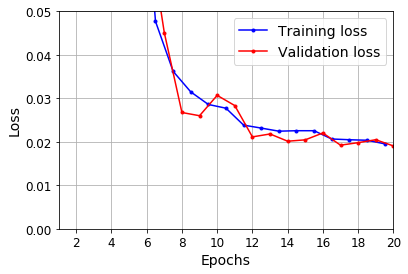

In [27]:
# history.history.keys()
plot_learning_curves(history.history["last_time_step_mse"], history.history["val_last_time_step_mse"])
plt.show()

## Try binary classification dataset with LSTM

### Generate a (terrible) binary dataset

In [494]:
freq1, freq2, offsets1, offsets2 = np.random.randint(15, size=(4, 2, 4, 2))
series = (freq2 * (offsets1 + 10)) + (freq1 + offsets2)
targets = np.where(np.sum(series, axis=2)//4<100,0,1)
targets =targets[...,np.newaxis]
print(series)
print(targets)

[[[ 96  47]
  [127  57]
  [133  29]
  [218 100]]

 [[135 316]
  [126  66]
  [154  22]
  [185  22]]]
[[[0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]]]


We'll create a binary dataset with a 0/1 target class. Importantly, we will give this dataset multiple features per time step.

We're going to also log our models to Tensorboard this time. Use function below to create directories for our model logs.

### Log to Tensorboard

In [304]:
def get_run_logdir(folder_name):
    root_logdir = os.path.join(os.curdir, folder_name)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

def prep_run():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
run_name = get_run_logdir('some_name')
run_name

'./some_name/run_2020_05_01-21_18_16'

In [270]:
# generate a binary dataset

def generate_binary_sequences(batch_size, n_steps, n_features):
    freq1, freq2, offsets1, offsets2 = np.random.randint(15, size=(4, batch_size, n_steps, n_features))
    series = (freq2 * (offsets1 + 10)) + (freq1 + offsets2)
    targets = np.where(np.sum(series, axis=2)//4<700,0,1)
    targets =targets[...,np.newaxis]
    return series.astype(int), targets.astype(int)

In [360]:
samples = 1000
n_steps = 100
features = 20
train_count = 700
val_idx = 900 # starting val set from what index

dataset, targets = generate_binary_sequences(samples, n_steps, features)
# targets = generate_binary_target(samples, n_steps)

x_train, y_train = dataset[:train_count], targets[:train_count]
x_val, y_val = dataset[train_count:val_idx], targets[train_count:val_idx]
x_test, y_test = dataset[val_idx:], targets[val_idx:]

targets.shape

(1000, 100, 1)

In [361]:
x_train.shape

(700, 100, 20)

There is some bias in our dataset - so we're going to adjust our output layer with the bias_initializer attribute. It may not help.

In [272]:
# find the bias in dataset classes:
neg, pos = np.bincount(targets[:,:,0].flatten())
total = targets[:,:,0].flatten().shape
# output counts of classes.
print('pos %: {} neg %: {}'.format(pos/total*100,neg/total*100))
initial_bias = np.log([pos/neg])
initial_bias = tf.keras.initializers.Constant(initial_bias)

pos %: [34.7] neg %: [65.3]


### Try our fake dataset on binary LSTM model.

Now we can fit our model. We're using LSTM with a dropout layer. And because the input contains multiple features per timestep, we're going to use the TimeDistributed layer wrapped around the output layer.

In [616]:
binary_model = keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True, input_shape=(None,features)),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias))
])
binary_model._name='binary_lstm_test'
binary_model.summary()

Model: "binary_lstm_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          3280      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dropout (Dropout)            (None, None, 20)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           21        
Total params: 9,861
Trainable params: 9,861
Non-trainable params: 0
_________________________________________________________________


In [617]:
prep_run()
run_logdir = get_run_logdir("test_lstm_logs")
print(run_logdir)

# can't use class weights for 3D array :(
# class_weight = {0: 1.,
#                 1: 50.}
tb = TensorBoard(run_logdir)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='binary_crossentropy',
                                          patience=3, 
                                          verbose=1,
                                          factor=0.5, 
                                          min_lr=0.00001)
binary_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['binary_crossentropy', 'Precision','Recall', 'accuracy'])

history = binary_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=10, callbacks=[tb, lr])

./test_lstm_logs/run_2020_04_22-15_45_03
Train on 700 samples, validate on 200 samples
Epoch 1/10
700/700 [==============================] - 10s 14ms/sample - loss: 0.6470 - binary_crossentropy: 0.6470 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.6531 - val_loss: 0.6419 - val_binary_crossentropy: 0.6419 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6588
Epoch 2/10
700/700 [==============================] - 3s 5ms/sample - loss: 0.6459 - binary_crossentropy: 0.6459 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.6531 - val_loss: 0.6420 - val_binary_crossentropy: 0.6420 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6588
Epoch 3/10
700/700 [==============================] - 3s 5ms/sample - loss: 0.6455 - binary_crossentropy: 0.6455 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.6531 - val_loss: 0.6417 - val_binary_crossentropy: 0.6417 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 

In [614]:
scores = binary_model.evaluate(x_val, y_val)

200/200 [==============================] - 0s 1ms/sample - loss: 0.6397 - binary_crossentropy: 0.6397 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.6588


In [615]:
print('binary_crossentropy {}, Precision {}, Recall {}, Accuracy {}'.format(scores[0], scores[1], scores[2], scores[3]))
# binary_crossentropy 0.6377848553657531, Precision 0.6377848386764526, Recall 0.0, Accuracy 0.0

binary_crossentropy 0.6396739101409912, Precision 0.6396739482879639, Recall 0.0, Accuracy 0.0


In [567]:
y_pred = binary_model.predict_classes(x_val[:,:,:])
y_actual = y_val[:,:,:]

print('y_pred: {} y_actual: {}'.format(y_pred.shape, y_actual.shape))
print(classification_report(y_actual.flatten(), y_pred.flatten()))
y_pred.shape

y_pred: (200, 100, 1) y_actual: (200, 100, 1)
              precision    recall  f1-score   support

           0       0.66      1.00      0.79     13176
           1       0.00      0.00      0.00      6824

    accuracy                           0.66     20000
   macro avg       0.33      0.50      0.40     20000
weighted avg       0.43      0.66      0.52     20000



/Users/htahir/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(200, 100, 1)

Our model is not doing so well! Let's plot the loss.

(0, 1)

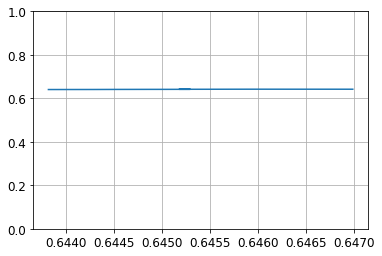

In [619]:
plt.plot(history.history['loss'],history.history['val_loss'],)
# history.history.keys()
plt.grid(True)
plt.gca().set_ylim(0, 1)

Okay, maybe the dataset isn't the best...but we cna retry it with a basic NN.

## Test a feedforward NN on the binary dataset

We don't know if it's our dataset that's the issue...or the model. If this also sucks, our dataset might be an issue.

Set up the model, compile, and run a simple feedforward NN.

In [674]:
prep_run()
run_logdir = get_run_logdir("test_lstm_logs")
print(run_logdir)

# build simple OLS model

ffwd_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps,features], name='input'),
#     keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1], name='input'),
    keras.layers.Dense(32, activation='relu', name='hidden_1'),
    keras.layers.Dense(32, activation='relu', name='hidden_2'),
#     keras.layers.SimpleRNN(32, return_sequences=True),
#     keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, name='output')
])
ffwd_model.summary()

./test_lstm_logs/run_2020_04_22-21_53_44
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 2000)              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                64032     
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 65,121
Trainable params: 65,121
Non-trainable params: 0
_________________________________________________________________


In [675]:
tb = TensorBoard(run_logdir)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='binary_crossentropy',
                                          patience=3, 
                                          verbose=1,
                                          factor=0.5, 
                                          min_lr=0.00001)
ffwd_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['binary_crossentropy', 'Precision','Recall', 'accuracy'])

history = binary_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[tb])

Train on 700 samples, validate on 200 samples
Epoch 1/10
700/700 [==============================] - 6s 8ms/sample - loss: 0.6431 - binary_crossentropy: 0.6431 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.6531 - val_loss: 0.6393 - val_binary_crossentropy: 0.6393 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6588
Epoch 2/10
700/700 [==============================] - 3s 4ms/sample - loss: 0.6419 - binary_crossentropy: 0.6419 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.6531 - val_loss: 0.6376 - val_binary_crossentropy: 0.6376 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6588
Epoch 3/10
700/700 [==============================] - 3s 4ms/sample - loss: 0.6397 - binary_crossentropy: 0.6397 - Precision: 0.2500 - Recall: 4.1184e-05 - accuracy: 0.6531 - val_loss: 0.6333 - val_binary_crossentropy: 0.6333 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6588
Epoch 4/10
700/700 [====================

In [929]:
# we'll go back in and add bias initializer ot output layer:

# find the bias in dataset classes:
neg, pos = np.bincount(df_y3[:,0])
total = df_y.shape[0]
# total
# # output counts of classes.
print('pos %: {} neg %: {}'.format(pos/total*100,neg/total*100))

# calculate bias to be used in output layer
initial_bias = np.log([pos/neg])
print('initial_bias: ',initial_bias)
initial_bias = tf.keras.initializers.Constant(initial_bias)

pos %: 29.4 neg %: 70.6
initial_bias:  [-0.87603547]


So, it may actually be the dataset....we may need to try real data.

## Use a real dataset to learn about LSTMs

In [747]:
# let's use real data
df = pd.read_excel('/Users/htahir/Documents/SCS_machine_learning/datasets/loans/Bank_Personal_Loan_Modelling.xlsx', 'Data')
# also create a 3D array becasue keras likes those

In [686]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [748]:
df.drop(columns=['ID', 'ZIP Code'], inplace=True)

In [749]:
# create our target values.
df_y = df.pop('CreditCard')
df_y.shape

(5000,)

In [701]:
df.isna().sum()

Age                   0
Experience            0
Income                0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
dtype: int64

In [693]:
df_y.to_frame()

,CreditCard
0,0
1,0
2,0
3,0
4,1
...,...
4995,0
4996,0
4997,0
4998,0


For keras, we need to reformat our dataset to 3D:

In [855]:
df_y3 = np.array(df_y)
df_y3 = df_y3[...,np.newaxis]

df_3 = np.array(df)
df_3 = df_3[...,np.newaxis]
df_3.shape, df_y3.shape

((5000, 11, 1), (5000, 1))

In [845]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df, df_y, test_size=0.30, random_state=43)
print(x_train.shape, y_train.shape)

# create val sets
x_val = x_train[3000:]
y_val = y_train[3000:]

x_train = x_train[:3000]
y_train = y_train[:3000]

(3500, 11) (3500,)


In [856]:
# do the same for the 3D sets
from sklearn.model_selection import train_test_split
x3_train, x3_test, y3_train, y3_test = train_test_split(df_3, df_y3, test_size=0.30, random_state=43)

# create val sets
x3_val = x3_train[3000:]
y3_val = y3_train[3000:]

x3_train = x3_train[:3000]
y3_train = y3_train[:3000]

print('train: ', x3_train.shape, y3_train.shape)
print('val: ', x3_val.shape, y3_val.shape, )

train:  (3000, 11, 1) (3000, 1)
val:  (500, 11, 1) (500, 1)


In [824]:
x_train.shape[1:]

(11,)

### Using simple NN on real dataset:

In [292]:
# build simple OLS model
def build_ols_model(input, **kwargs):
    model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[input], name='input'),
#     keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1], name='input'),
    keras.layers.Dense(32, activation='relu', name='hidden_1'),
    keras.layers.Dense(32, activation='relu', name='hidden_2'),
    keras.layers.Dense(1, activation='sigmoid',name='output')
])
    return model

In [714]:

prep_run()
run_logdir = get_run_logdir("test_lstm_logs")
print(run_logdir)

loan_model = build_ols_model(x_train.shape[1])
loan_model.summary()

./test_lstm_logs/run_2020_04_22-22_40_44
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 11)                0         
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                384       
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


In [715]:

# class_weight = {0: 1.,
#                 1: 50.}
tb = TensorBoard(run_logdir)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='binary_crossentropy',
                                          patience=3, 
                                          verbose=1,
                                          factor=0.5, 
                                          min_lr=0.00001)
loan_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['binary_crossentropy', 'Precision','Recall', 'accuracy'])

history = loan_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, callbacks=[tb, lr])


Train on 3000 samples, validate on 500 samples
Epoch 1/20
3000/3000 [==============================] - 1s 491us/sample - loss: 0.9015 - binary_crossentropy: 0.9015 - Precision: 0.2770 - Recall: 0.1339 - accuracy: 0.6430 - val_loss: 0.6660 - val_binary_crossentropy: 0.6660 - val_Precision: 0.3030 - val_Recall: 0.1316 - val_accuracy: 0.6440
Epoch 2/20
3000/3000 [==============================] - 0s 78us/sample - loss: 0.6873 - binary_crossentropy: 0.6873 - Precision: 0.3239 - Recall: 0.1305 - accuracy: 0.6647 - val_loss: 0.6377 - val_binary_crossentropy: 0.6377 - val_Precision: 0.3684 - val_Recall: 0.0461 - val_accuracy: 0.6860
Epoch 3/20
3000/3000 [==============================] - 0s 85us/sample - loss: 0.6590 - binary_crossentropy: 0.6590 - Precision: 0.2798 - Recall: 0.0692 - accuracy: 0.6743 - val_loss: 0.6358 - val_binary_crossentropy: 0.6358 - val_Precision: 0.3750 - val_Recall: 0.0197 - val_accuracy: 0.6920
Epoch 4/20
3000/3000 [==============================] - 0s 80us/sample - 

That did okay. Now we try our LSTM model.

### Using LSTM model instead.

In [293]:
def simple_LSTM(inputA, initial_bias_, **kwargs):
    model = keras.models.Sequential([
        keras.layers.LSTM(100, input_shape=[None, inputA], return_sequences=True),
        keras.layers.LSTM(100),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias_)
])
    return model

In [294]:
binary_model = simple_LSTM(1, initial_bias)
binary_model._name='binary_lstm_test'
binary_model.summary()

Model: "binary_lstm_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 100)         40800     
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [938]:

# class_weight = {0: 1.,
#                 1: 50.}
tb = TensorBoard(run_logdir)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='binary_crossentropy',
                                          patience=3, 
                                          verbose=1,
                                          factor=0.5, 
                                          min_lr=0.00001)
binary_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                    metrics=['binary_crossentropy', 'Precision','Recall', 'accuracy'])

history = binary_model.fit(x3_train, y3_train, validation_data=(x3_val, y3_val), epochs=40, callbacks=[tb, lr])


Train on 3000 samples, validate on 500 samples
Epoch 1/40
3000/3000 [==============================] - 7s 2ms/sample - loss: 0.6119 - binary_crossentropy: 0.6119 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.7063 - val_loss: 0.6146 - val_binary_crossentropy: 0.6146 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6960
Epoch 2/40
3000/3000 [==============================] - 2s 732us/sample - loss: 0.6068 - binary_crossentropy: 0.6068 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.7063 - val_loss: 0.6155 - val_binary_crossentropy: 0.6155 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6960
Epoch 3/40
3000/3000 [==============================] - 2s 757us/sample - loss: 0.6071 - binary_crossentropy: 0.6071 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.7063 - val_loss: 0.6135 - val_binary_crossentropy: 0.6135 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6960
Epoch 4/40
3000/3000 [===

In [939]:
scores = binary_model.evaluate(x3_val, y3_val)

500/500 [==============================] - 0s 246us/sample - loss: 0.5405 - binary_crossentropy: 0.5405 - Precision: 0.9091 - Recall: 0.1974 - accuracy: 0.7500


Let's plot classification report from sklearn.

In [941]:
y_pred = binary_model.predict_classes(x3_val[:,:,:])
y_actual = y3_val[:,:]

print('y_pred: {} y_actual: {}'.format(y_pred.shape, y_actual.shape))
print(classification_report(y_actual.flatten(), y_pred.flatten()))
y_pred.shape

y_pred: (500, 1) y_actual: (500, 1)
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       348
           1       0.91      0.20      0.32       152

    accuracy                           0.75       500
   macro avg       0.82      0.59      0.59       500
weighted avg       0.79      0.75      0.69       500



(500, 1)

It's really good a preoicting only one class. Let's keep optimizing.

## Use a stable LSTM on same dataset

In [961]:
# stateful LSTM
def stateful_LSTM(inputA, initial_bias_, batch_size, lahead):
    model = keras.models.Sequential([
        keras.layers.LSTM(100, input_shape=[lahead, inputA], stateful=True, batch_size=batch_size, return_sequences=True),
        keras.layers.LSTM(100),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias_)
])    
    return model

tsteps = 2

# The input sequence length that the LSTM is trained on for each output point
lahead = 11

# training parameters passed to "model.fit(...)"
batch_size = 1
epochs = 10

binary_model = stateful_LSTM(1, initial_bias, batch_size, lahead)
binary_model._name='stateful_binary_lstm_test'
binary_model.summary()
binary_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                    metrics=['binary_crossentropy', 'Precision','Recall', 'accuracy'])



Model: "stateful_binary_lstm_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (1, 11, 100)              40800     
_________________________________________________________________
lstm_91 (LSTM)               (1, 100)                  80400     
_________________________________________________________________
dropout_26 (Dropout)         (1, 100)                  0         
_________________________________________________________________
dense_39 (Dense)             (1, 1)                    101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [962]:
for i in range(epochs):
    print('Epoch', i + 1, '/', epochs)
    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be
    # extracted with data_input[i::batch_size].
    binary_model.fit(x3_train, y3_train, 
                       validation_data=(x3_val, y3_val),
                       batch_size=batch_size,
                       epochs=1,
                       verbose=1,
                       shuffle=False)
    binary_model.reset_states()

Epoch 1 / 10
Train on 3000 samples, validate on 500 samples
3000/3000 [==============================] - 37s 12ms/sample - loss: 0.6125 - binary_crossentropy: 0.6125 - Precision: 0.3611 - Recall: 0.0148 - accuracy: 0.7030 - val_loss: 0.6158 - val_binary_crossentropy: 0.6158 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6960
Epoch 2 / 10
Train on 3000 samples, validate on 500 samples
3000/3000 [==============================] - 33s 11ms/sample - loss: 0.6108 - binary_crossentropy: 0.6108 - Precision: 0.3750 - Recall: 0.0068 - accuracy: 0.7050 - val_loss: 0.6147 - val_binary_crossentropy: 0.6147 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6960
Epoch 3 / 10
Train on 3000 samples, validate on 500 samples
3000/3000 [==============================] - 34s 11ms/sample - loss: 0.6080 - binary_crossentropy: 0.6080 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.7063 - val_loss: 0.6158 - val_binary_crossentropy: 0.6158 - val_Precision

In [976]:
y_pred = binary_model.predict_classes(x3_val[:,:,:], batch_size=batch_size)
y_actual = y3_val[:,:]

print('y_pred: {} y_actual: {}'.format(y_pred.shape, y_actual.shape))
print(classification_report(y_actual.flatten(), y_pred.flatten()))
y_pred.shape

y_pred: (500, 1) y_actual: (500, 1)
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       348
           1       0.00      0.00      0.00       152

    accuracy                           0.70       500
   macro avg       0.35      0.50      0.41       500
weighted avg       0.48      0.70      0.57       500



/Users/htahir/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(500, 1)

In [973]:
x3_val.shape

(500, 11, 1)

# Transform our dataset for keras.

In [595]:
pwd = '/Users/htahir/Documents/SCS_machine_learning/Final_Project/'

# load our clean dataset:

df = pd.read_csv(pwd+'ecommerce_merged_data.csv', nrows=500000,infer_datetime_format=True, parse_dates=[8])
# df = df.query('visitorid in (552148, 189384)').copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
timestamp        500000 non-null object
visitorid        500000 non-null int64
event            500000 non-null object
itemid           500000 non-null int64
transactionid    4185 non-null float64
categoryid       455357 non-null float64
parentid         455354 non-null float64
sessionid        500000 non-null object
date             500000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 34.3+ MB


The goal of the Keras model is to predict conversion vs non-conversion of a user based on their historical buying behaviour. We will not train the model on exactly WHAT item the user is buying (because there are literally over a 100,000 of them). However, we'll train on on the parent categories of an item a visitor has bought from historically.

Let's load our clean dataset.

In [4]:
df.head()

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid,sessionid,date
0,2015-06-02 01:02:12,257597,view,355908,NaN,1173.0,805.0,2015-06-02_257597,2015-06-02
1,2015-06-02 01:50:14,992329,view,248676,NaN,1231.0,901.0,2015-06-02_992329,2015-06-02
2,2015-06-02 01:13:19,111016,view,318965,NaN,NaN,NaN,2015-06-02_111016,2015-06-02
3,2015-06-02 01:12:35,483717,view,253185,NaN,914.0,226.0,2015-06-02_483717,2015-06-02
4,2015-06-02 01:02:17,951259,view,367447,NaN,491.0,679.0,2015-06-02_951259,2015-06-02


We're going to build a transformer to quickly clean up our dataset, dropping any unwaved columns and changing data types.

In [91]:
# custom transformer to drop any useless data

class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        pass
    def transform(self, X, y=None):
        df = X.drop(columns=self.cols)
        return df
    
class DropNulls(BaseEstimator, TransformerMixin):
    def __init__(self, drop_nulls=True):
        self.drop_nulls = drop_nulls
    def fit(self, X, y=None):
        pass
    def transform(self, X, y=None):
        if self.drop_nulls==True:
            df = X.dropna(inplace=False)
            df = df.reset_index(inplace=False, drop=True)
            return df
        else:
            pass
        return df
    
class ChangeColType(BaseEstimator, TransformerMixin):
    def __init__(self, cols, newType):
        self.cols = cols
        self.newType = newType
    def fit(self, X, y=None):
        pass
    def transform(self, X, y=None):
        for col in self.cols:
            X[col] = X[col].astype(self.newType)
        return X


In [265]:
CleanRawData = make_pipeline(
    DropColumn(['transactionid', 'sessionid', 'timestamp']),
    DropNulls(),
    ChangeColType(['categoryid', 'parentid'],int)
)
df = CleanRawData.transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45682 entries, 0 to 45681
Data columns (total 6 columns):
visitorid     45682 non-null int64
event         45682 non-null object
itemid        45682 non-null int64
categoryid    45682 non-null int64
parentid      45682 non-null int64
date          45682 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 2.1+ MB


### Feature Engineer our dataset for Neural Network

We're going to do some quick feature engineering before we start reshaping our dataset for a neural network. This will allow us to provide the model some additional information.  

We're going to add weekday as a feature, as ther eis a good chance of a wekly buying patttern.

In [266]:
# build a transformer to extract weekday as a feature

class WeekdayExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        weekday = X.progress_apply(lambda x: 'weekday_'+ str(x.weekday()))
        return weekday.rename('weekday').to_frame()


In [596]:
# pipeline to extract weekday
wkday_pipeline = Pipeline(steps=[
    ('wkday', WeekdayExtractor()),
    ('onehot', OneHotEncoder())
])

transformed = wkday_pipeline.fit_transform(df['date'])
ohe_df = pd.DataFrame.sparse.from_spmatrix(transformed, 
                                           columns=wkday_pipeline['onehot'].get_feature_names())

df = pd.concat([df, ohe_df], axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 16 columns):
timestamp        -500000 non-null object
visitorid        -500000 non-null int64
event            -500000 non-null object
itemid           -500000 non-null int64
transactionid    -995815 non-null float64
categoryid       -544643 non-null float64
parentid         -544646 non-null float64
sessionid        -500000 non-null object
date             -500000 non-null datetime64[ns]
x0_weekday_0     -500000 non-null Sparse[float64, 0.0]
x0_weekday_1     -500000 non-null Sparse[float64, 0.0]
x0_weekday_2     -500000 non-null Sparse[float64, 0.0]
x0_weekday_3     -500000 non-null Sparse[float64, 0.0]
x0_weekday_4     -500000 non-null Sparse[float64, 0.0]
x0_weekday_5     -500000 non-null Sparse[float64, 0.0]
x0_weekday_6     -500000 non-null Sparse[float64, 0.0]
dtypes: Sparse[float64, 0.0](7), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 40.1+ MB


In [597]:
df.visitorid.unique().shape

(258583,)

Our keras model needs the dataset to be in a 3D array of shape (visitors, num visits/timesteps, features).

The way our dataset is set up, we can't just split the "events" data into train and test. We have to preseve the history of each user (i.e. users must not be split across train and test).

So here is the plan:

1. Create a daily-level dataframe of featuers per visitor:  
    a. Pivot entire dataset on daily visitor level so that parentIDs become columns with view counts and add to cart counts per each parentID (we'll make separate DFs for each event type).  
    b. To avoid differing numbers of parentID columns in current and any future data, we're going to join it to an empty dataframe that contains column of every single parentID in our dataset).  
    c. Combine our views DF and addtoCart DF to create a final daily record per user.
2. Create timestep arrays: 
    a. find max timesteps (this will be the length of our timestep array).  
    b. create a list per user containing lists of features per timestep.  
    c. Combine the lists to create our final array with a row for every visitor's timestep sequence.
    d. Split out into train/test.
3. Preprocess our training data.  
    a. Combine every feature vector into one input array and pad it to same length.

### Create a daily-level dataframe of features per visitor:  

Let's find some sample users who converted, to avoid running the entire dataset while we work on trasnforming it.

To create our features array, we'll create 3 aggregated DFs on visitor and date level (one for each event: view, add to cart, purchase). One will count # views per categoryid per user daily, the second will count add to cart, the third will count purchases per visitor per day, which we'll convert to 0/1. In our case, we don't care what the user purchased, just that they made a purchase, and that's what we want our model to predict.

We'll also create a fourth dataframe that is empty and contains a column for every parent ID in our dataset. This will be merged individually with the views and add to cart dataframes to ensure all our input data is of equal length (and that we never miss a categoryID regardless of if our current dataset has it). So now we ahve two arrays, both of equal number of columns. 

Now we join them together to create a DF twice as wide (with a column for every category's view and addtocart values separately). This will give us daly-level activity for every single user.

The custom transformer below does all this for us.

In [598]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 16 columns):
timestamp        -500000 non-null object
visitorid        -500000 non-null int64
event            -500000 non-null object
itemid           -500000 non-null int64
transactionid    -995815 non-null float64
categoryid       -544643 non-null float64
parentid         -544646 non-null float64
sessionid        -500000 non-null object
date             -500000 non-null datetime64[ns]
x0_weekday_0     -500000 non-null Sparse[float64, 0.0]
x0_weekday_1     -500000 non-null Sparse[float64, 0.0]
x0_weekday_2     -500000 non-null Sparse[float64, 0.0]
x0_weekday_3     -500000 non-null Sparse[float64, 0.0]
x0_weekday_4     -500000 non-null Sparse[float64, 0.0]
x0_weekday_5     -500000 non-null Sparse[float64, 0.0]
x0_weekday_6     -500000 non-null Sparse[float64, 0.0]
dtypes: Sparse[float64, 0.0](7), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 40.1+ MB


In [599]:
class ReshapeDataset(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # create an empty df with all category vals
        self.cat_df = pd.DataFrame(columns=X.parentid.unique().tolist())
        return self
    
#     def get_bias(self, col):
#         self.neg, self.pos = np.bincount(col, minlength=0)
#         self.bias = np.log(self.pos/self.neg)
#         print(self.bias)
#         self.bias = tf.keras.initializers.Constant(self.bias)
#         return self.bias
        
    def transform(self, X, y=None):
        # create 3 dfs for views, adds, purch
        
        # views
        # removing sample visitorid in (552148, 189384) 
        print('Creating views pivot table...')
        self.df_sample = X.query('event == "view" ').copy()
        self.df_views = pd.pivot_table(self.df_sample, index=['date','visitorid',
                                                              'x0_weekday_0','x0_weekday_1',
                                                              'x0_weekday_2','x0_weekday_3',
                                                              'x0_weekday_4','x0_weekday_5', 
                                                              'x0_weekday_6'
                                                             ], 
                                columns=['parentid'], values='itemid',aggfunc='count', fill_value=0)
        self.df_views = self.df_views.reset_index()
        print('views df shape: ',self.df_views.shape)
        
        # add to cart
        print('Creating add-to-cart pivot table...')
        self.df_sample2 = X.query('event == "addtocart" ').copy()
        self.df_adds = pd.pivot_table(self.df_sample2, index=['date','visitorid'], 
                                columns=['parentid'], values='itemid',aggfunc='count', fill_value=0)
        self.df_adds = self.df_adds.reset_index()
        print('adds df shape: ',self.df_adds.shape)

        # purchases
        print('Creating transactions pivot table...')
        self.df_sample3 = X.query('event == "transaction" ').copy()
        self.df_convert = pd.pivot_table(self.df_sample3, index=[ 'date','visitorid'], 
                                columns=['event'], values='itemid',aggfunc='count', fill_value=0)
        self.df_convert = self.df_convert.reset_index()
        
        # join views and cart to category df 
        print('Merging parentID dataframe to views and add-to-cart separately...')
        self.df_fullview = self.df_views.merge(self.cat_df, how='outer', on=None)
        self.df_fulladds = pd.merge(self.df_adds, self.cat_df, how='outer', on=None)
        
        # merge both views and cart together
        print('...and merging both of them together.')
        self.full_df = self.df_fullview.merge(self.df_fulladds, 
                            how='outer', on=['date','visitorid'], 
                            suffixes=('_views', '_adds'))
        
        print('Creating target vector...')
        # create our target vector by changing column values to binary
        self.df_convert['transaction'] = np.where(self.df_convert['transaction']>0,1,0)
        
        # use this to find bias value
#         print('Calculating bias...')
#         self.initial_bias = self.get_bias(self.df_convert['transaction'])
        
        # merge target DF with the main features DF to make it easier 
        # to create our final input and target arrays.
        self.full_df = self.full_df.merge(self.df_convert, how="outer", on=["visitorid", "date"])
        self.full_df.fillna(0, inplace=True)
        
        print('Returning results. Proces complete.')
        return self.full_df

In [600]:
dataset = ReshapeDataset().fit_transform(df)
dataset.shape

Creating views pivot table...
views df shape:  (252415, 272)
Creating add-to-cart pivot table...
adds df shape:  (7561, 209)
Creating transactions pivot table...
Merging parentID dataframe to views and add-to-cart separately...
...and merging both of them together.
Creating target vector...
Returning results. Proces complete.


(253119, 538)

In [272]:
dataset.head()
# dataset.shape

,date,visitorid,x0_weekday_0,x0_weekday_1,x0_weekday_2,x0_weekday_3,8_views,9_views,14_views,20_views,...,336_adds,732_adds,1669_adds,1374_adds,275_adds,1632_adds,265_adds,140_adds,1591_adds,transaction
0,2015-06-01,17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
1,2015-06-01,4078,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
2,2015-06-01,10946,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
3,2015-06-01,27647,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
4,2015-06-01,50966,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0


In [274]:
# dataset[dataset['visitorid']==189384]
# data2 = dataset.reset_index(drop=True, inplace=False)
# data2.head()

In [19]:
# full_dataset = dataset.to_numpy()
# full_dataset.shape

(522686, 2118)

In [20]:
# def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
#     ecommerce_dir = os.path.join("datasets", "ecommerce")
#     os.makedirs(ecommerce_dir, exist_ok=True)
#     path_format = os.path.join(ecommerce_dir, "ecommerce_{}_{:02d}.csv")

#     filepaths = []
#     m = len(data)
#     for file_idx, row_indices in tqdm_notebook(enumerate(np.array_split(np.arange(m), n_parts)), desc="Creating data files:"):
#         part_csv = path_format.format(name_prefix, file_idx)
#         filepaths.append(part_csv)
#         with open(part_csv, "wt", encoding="utf-8") as f:
#             if header is not None:
#                 f.write(header)
#                 f.write("\n")
#             for row_idx in row_indices:
#                 f.write(",".join([repr(col) for col in data[row_idx]]))
#                 f.write("\n")
#     return filepaths


In [ ]:
# # split out data set into train and test

# train, test = train_test_split(full_dataset, test_size=0.3, random_state=42)
# train, validation = train_test_split(train, test_size=0.3, random_state=42)

# header_cols = dataset.columns.tolist()
# header_cols = ','.join(header_cols)
# train.shape

In [ ]:

# print('Saving train set...')
# train_filepaths = save_to_multiple_csv_files(train, "train", header_cols, n_parts=20)
# print('Saving validation set...')
# valid_filepaths = save_to_multiple_csv_files(validation, "valid", header_cols, n_parts=10)
# print('Saving test set...')
# test_filepaths = save_to_multiple_csv_files(test, "test", header_cols, n_parts=10)

# train_filepaths[:3]

In [9]:
# find max timesteps
# timesteps = dataset.groupby('visitorid')['date'].count().max()
# print(timesteps, " timesteps")
# timesteps = 26

Let's reload the data one file at a time and use each file to create a list of lists per user.

In [7]:
# n_inputs = 9 # X_train.shape[-1]

# @tf.function
# def preprocess(line):
#     defs = [0] * n_inputs + [tf.constant([], dtype=tf.int32)]
#     fields = tf.io.decode_csv(line, record_defaults=defs)
#     x = tf.stack(fields[:-1])
#     y = tf.stack(fields[-1:])
#     return x, y

In [8]:
preprocess(b'1,  0,  0,  0,  0,  0,  0,  2, 14,  0')

(<tf.Tensor: shape=(9,), dtype=int32, numpy=array([ 1,  0,  0,  0,  0,  0,  0,  2, 14], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)

### Create timestep array

Next, we'll take that full dataset with every parentID, and reshape it into a list of lists of lists:

- outer list: contains a row per user
- each row: contains a list per timestep
- timestep list: contains a list of features for that timestep

While creating the features array, we'll also handle the target array, which wil have the same form of being a nested list of lists (except that it will only have one "feature" per timestep per user - the class).

In the end, we'll have two lists: one for features, one for targets.

In [275]:
class CreateInputArray(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # find max timesteps
        self.max_timesteps = X.groupby('visitorid')['date'].count().max()
        print(self.max_timesteps, " timesteps")
        return self
        
    def transform(self, X, y=None):
        
        self.users = X.visitorid.unique()
        self.user_list = [] 
        self.target_list = []
        
        for i in tqdm_notebook(self.users, desc="creating features/targets array"):
            self.temp_df = X[X.visitorid == i].copy()
            self.t = self.temp_df['transaction'].astype(int).values.tolist()
            self.target_list.append(self.t)
            self.temp_df.drop(columns=['visitorid', 'date'], inplace=True)
            self.record = self.temp_df.values.tolist()
            self.user_list.append(self.record)
        
        print('sequence sample of first visitor:')
        print("feature array: ", self.user_list[1][0][0:10])
        print("targets: ",self.target_list[0])
        
        return self.user_list, self.target_list

In [601]:
features, targets = CreateInputArray().fit_transform(dataset)

26  timesteps



sequence sample of first visitor:
feature array:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
targets:  [0]


In [125]:
# save backup
# df_fullview.to_csv('full_views.csv')
# df_fulladds.to_csv('full_adds.csv')
# print('Done saving.')

Done saving.


### Split into train/test

Now that we have our dataset at a level where we can split it into train/test withouot splitting a user betwen the two, we'll do that first, and then transform our train set into a time series for our model.

In [610]:
X = np.array(features)
y = np.array(targets)
print("X and Y: " , X.shape, y.shape)

# split out data set into train and test
print('Splitting out train/test/val.')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print('X_train and y_train shapes:')
print(X_train.shape, y_train.shape)
print('input sample: ', X_train[0][0][:10])

print('X_val and y_val shapes:')
print(X_val.shape, y_val.shape)
print('input sample: ', X_val[0][0][:10])

print('X_test and y_test shapes:')
print(X_test.shape, y_test.shape)
print('input sample: ', X_val[0][0][:10])

X and Y:  (226574,) (226574,)
Splitting out train/test/val.
X_train and y_train shapes:
(118950,) (118950,)
input sample:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
X_val and y_val shapes:
(39651,) (39651,)
input sample:  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
X_test and y_test shapes:
(67973,) (67973,)
input sample:  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Preprocess our training data

We now have our training data ready to be preprocessed.  
Here we decide that for the sake of keeping this a bit more time-efficient, we'll be front-padding all timesteps for users who have fewer than the max num of timesteps. Ideally, we'd properly map the timestep with the day of the period, but that might have to be a latter iteration!

#### Testing with a fake dataset. Skip to next section.

In [355]:
test_df = pd.DataFrame({'Owner': ['Bob', 'Jane', 'Kat', 'Bob'],
                        'Cat':[1, 1, 0, 0], 
                        'Age':[10,3, 2, 3]})
test_targets = np.random.randint(2, size=(3, 2, 1))
print(test_targets)
print(test_df.head())
users = test_df.Owner.unique()
user_list = [] 
for i in users:
    temp_df = test_df[test_df.Owner == i].copy()
#     print(temp_df.head())
    temp_df.drop(columns='Owner', inplace=True)
    record = temp_df.values.tolist()
#     print(record)
    user_list.append(record)
print('sequence list:')
print(user_list)


[[[0]
  [1]]

 [[0]
  [0]]

 [[0]
  [1]]]
  Owner  Cat  Age
0   Bob    1   10
1  Jane    1    3
2   Kat    0    2
3   Bob    0    3
sequence list:
[[[1, 10], [0, 3]], [[1, 3]], [[0, 2]]]


In [353]:
test_targets

array([1, 0, 1, 1, 0, 0])

In [346]:
# nulayer = tf.keras.preprocessing.sequence.pad_sequences(
#     sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre',
#     value=0.0
# )_df.head()

padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(user_list,
                                                              padding='post')

print(padded_inputs)

padded_inputs.shape

[[[ 1 10]
  [ 0  3]]

 [[ 1  3]
  [ 0  0]]

 [[ 0  2]
  [ 0  0]]]


(3, 2, 2)

In [350]:
embedding = keras.layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)
masked_output = embedding(padded_inputs)

print(masked_output._keras_mask)
# print(masked_output.shape)

tf.Tensor(
[[[ True  True]
  [False  True]]

 [[ True  True]
  [False False]]

 [[False  True]
  [False False]]], shape=(3, 2, 2), dtype=bool)


In [317]:
masking_layer = keras.layers.Masking()
# Simulate the embedding lookup by expanding the 2D input to 3D,
# with embedding dimension of 10.
unmasked_embedding = tf.cast(
    tf.tile(tf.expand_dims(padded_inputs, axis=0), [1, 1, 1, 1]),
    tf.float32)
unmasked_embedding
masked_embedding = masking_layer(unmasked_embedding)
print(masked_embedding._keras_mask)
print(masked_embedding)

tf.Tensor(
[[[ True  True]
  [ True False]
  [ True False]]], shape=(1, 3, 2), dtype=bool)
tf.Tensor(
[[[[ 1. 10.]
   [ 0.  3.]]

  [[ 1.  3.]
   [ 0.  0.]]

  [[ 0.  2.]
   [ 0.  0.]]]], shape=(1, 3, 2, 2), dtype=float32)


In [286]:
# test bias
classA, classB = np.bincount(test_targets)
print(classA, classB)
test_bias = np.log(classA/classB)
test_bias = tf.keras.initializers.Constant(test_bias)
print(test_bias)

1 3


In [488]:
def masking_LSTM(inputA, initial_bias_=0.0, **kwargs):

    model = keras.models.Sequential([
        keras.layers.Masking(input_shape=[None, inputA], mask_value=0),
        keras.layers.LSTM(10, return_sequences=True),
        keras.layers.LSTM(10, return_sequences=True),
#         keras.layers.Dropout(0.3),
        keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias_))
])
    return model

In [363]:

a = np.array([[[0,0],[0,0],[2,0],[2,1],[1,0],[0,1]],[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],
                [[2,1],[1,1],[1,2],[2,3],[2,0],[1,10]]])
print(a.shape)
inputs = tf.keras.Input(shape=(None,2))
mask = tf.keras.layers.Masking(mask_value=0)(inputs)
out = tf.keras.layers.TimeDistributed(Dense(1,activation='sigmoid'))(mask)
model = tf.keras.Model(inputs=inputs,outputs=out)
q = model.predict(padded_inputs)
print (q)

(3, 6, 2)
[[[0.99999833]
  [0.9824194 ]]

 [[0.98029053]
  [0.5       ]]

 [[0.9359648 ]
  [0.5       ]]]


In [362]:
padded_inputs.shape, test_targets.shape

((3, 2, 2), (3, 2, 1))

In [375]:
test_masking_model = masking_LSTM(2, test_bias)
test_masking_model._name='test_masking_model'
print(test_masking_model.summary())

test_masking_model.compile(loss="binary_crossentropy", optimizer="adam", 
                           metrics=["accuracy", "binary_crossentropy"])
history = test_masking_model.fit(padded_inputs, test_targets, validation_split=0.25, epochs=2)

Model: "test_masking_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 2)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 10)          520       
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 10)          840       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           11        
Total params: 1,371
Trainable params: 1,371
Non-trainable params: 0
_________________________________________________________________
None
Train on 2 samples, validate on 1 samples
Epoch 1/2
2/2 [==============================] - 9s 5s/sample - loss: 0.4949 - accuracy: 0.6667 - binary_crossentropy: 0.6599 - val_loss: 0.1417 - val_accuracy: 1.0000 - val_binary_crossentropy: 0.

Model: "binary_lstm_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 2)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          1840      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dropout (Dropout)            (None, None, 20)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           21        
Total params: 8,421
Trainable params: 8,421
Non-trainable params: 0
________________________________________________

#### Reshaping our training data

We'll create a transformer to pad our sequences using Keras's pad_sequences() function. The fit_transform() function will later allow us to ensure our validation and test sets are all padded to the same legnth as our training data.

We'll also create a transformer to adjust the dimension of the targets array, as keras needs it to be 3-dimensional to predict a class per timestep.

In [280]:
timesteps = {}
class PadSequences(BaseEstimator, TransformerMixin):
    global timesteps
    def __init__(self, padding='pre'):
        self.padding = padding
    
    def fit(self, X, y=None):
        df = X
#         t = len(df)
        t = max([len(df[i]) for i in range(len(df))])
        step = {'steps':t}
        timesteps.update(step)
        return self
    
    def transform(self, X):
        df = tf.keras.preprocessing.sequence.pad_sequences(X,padding=self.padding, maxlen=timesteps['steps'])
        return df
    
    def fit_transform(self, X, **kwargs):
        return self.fit(X, y).transform(X)

class ExpandDims(BaseEstimator, TransformerMixin):
    
    def __init__(self, expandAxis):
        self.expandAxis = expandAxis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = tf.expand_dims(X, axis=self.expandAxis)
        return X
 

In [611]:
X_train = PadSequences('pre').fit_transform(X_train)
outputPipeline = make_pipeline(
    PadSequences('pre'),
    ExpandDims(2)
)
y_train = outputPipeline.transform(y_train)

X_train.shape, y_train.shape

((118950, 26, 536), TensorShape([118950, 26, 1]))

In [612]:
X_val = PadSequences('pre').transform(X_val)
y_val = outputPipeline.transform(y_val)
print('val shapes: ',X_val.shape, y_val.shape)

X_test = PadSequences('pre').transform(X_test)
y_test = outputPipeline.transform(y_test)
print('test shapes: ',X_test.shape, y_test.shape)


val shapes:  (39651, 26, 536) (39651, 26, 1)
test shapes:  (67973, 26, 536) (67973, 26, 1)


Looks good! Both input and output arrays are of the same length and dimension per user. We'll use a masking layer as the input layer of our model to ensure the model knows we've padded our inputs.

### Training RNN on ecommerce sequence data

In [636]:
# how many steps per epoch?
BATCH_SIZE = 10000
resampled_steps_per_epoch = np.round(X_train.shape[0]/BATCH_SIZE)
resampled_steps_per_epoch

12.0

In [643]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(2)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().shuffle(BATCH_SIZE).repeat()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache()
test_ds = test_ds.batch(BATCH_SIZE).prefetch(2)

In [638]:
# checking shape of our tf dataset
train_ds
for features, labels in train_ds.take(1):
    print(features.shape)
    print(labels.shape)

(10000, 26, 536)
(10000, 26, 1)


Lastly, before we run the mode, we'll calculate the bias of classes in X_train. This might be used in our model's output layer (where we'll use this bias to tell the moel our data is imbalanced in favour of one class).

In [615]:
# recalculating initial bias
neg, pos = np.bincount(X_train[:,:,0].flatten(), minlength=0)
initial_bias = np.log(pos/neg)
print(initial_bias)
print('class 0: {} class 1: {}'.format(neg,pos))
initial_bias = tf.keras.initializers.Constant(initial_bias)

-4.85748525509324
class 0: 3068855 class 1: 23845


In [639]:
def masking_LSTM(inputA, initial_bias_, **kwargs):

    model = keras.models.Sequential([
        keras.layers.Masking(input_shape=[None,inputA], mask_value=0, name="masking_layer"),
        keras.layers.BatchNormalization(momentum=0.999),
        keras.layers.LSTM(100, return_sequences=True, kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01), name="lstm_1"),
        keras.layers.LeakyReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(100, return_sequences=True, kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01),name="lstm_2"),
        keras.layers.Dropout(0.3),
        keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias_))
])
    return model

In [640]:
test_masking_model = masking_LSTM(X_train.shape[-1],initial_bias)
test_masking_model._name='LSTM_masking_model'
print(test_masking_model.summary())


Model: "LSTM_masking_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (None, None, 536)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, 536)         2144      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         254800    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, None, 100)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)  

In [641]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.001, s=20)

In [ ]:
prep_run()
run_logdir = get_run_logdir("test_lstm_logs")
print(run_logdir)

tb = TensorBoard(run_logdir)

red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='binary_crossentropy',
                                          patience=3, 
                                          verbose=1,
                                          factor=0.005, 
                                          min_lr=0.00001)
lr_sched = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

es = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', 
                                      patience=3, restore_best_weights=True)

test_masking_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(clipvalue=1.5, lr=0.001, beta_1=0.9, beta_2=0.999), 
                           metrics=["accuracy", "binary_crossentropy", "Precision", "Recall"])
history = test_masking_model.fit(train_ds, validation_data=val_ds, 
                                 epochs=20, callbacks=[tb, red_lr, es]) # no lr_sched


./test_lstm_logs/run_2020_05_02-17_47_58
Train for 12 steps, validate for 4 steps
Epoch 1/20
12/12 [==============================] - 219s 18s/step - loss: 8.9386 - accuracy: 0.9905 - binary_crossentropy: 0.0530 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 7.8117 - val_accuracy: 0.9907 - val_binary_crossentropy: 0.0527 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/20
12/12 [==============================] - 203s 17s/step - loss: 7.0137 - accuracy: 0.9905 - binary_crossentropy: 0.0528 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 6.1516 - val_accuracy: 0.9907 - val_binary_crossentropy: 0.0526 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 209s 17s/step - loss: 5.5466 - accuracy: 0.9905 - binary_crossentropy: 0.0527 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 4.8937 - val_accuracy: 0.9907 - val_binary_crossentropy: 0.0525 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history['loss'],history.history['val_loss'])
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [635]:
# ?test_masking_model.evaluate
# print('Evaluating...')
scores = test_masking_model.evaluate(X_val[:,:,:], y_val[:,:,:])
# print("Metrics: accuracy, binary_crossentropy, Precision, Recall: ",scores)

39651/39651 [==============================] - 123s 3ms/sample - loss: 0.0026 - accuracy: 0.9907 - binary_crossentropy: 0.0596 - Precision: 0.0000e+00 - Recall: 0.0000e+00


In [572]:
y_pred = test_masking_model.predict_classes(X_val[:3,:,:])
y_pred[:,:,0]

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

In [582]:
y_pred = test_masking_model.predict_classes(X_val[:,:,:])
y_actual = y_val[:,:,:]

print('y_pred: {} y_actual: {}'.format(y_pred.shape, y_actual.shape))
print(classification_report(tf.reshape(y_actual,[-1]), tf.reshape(y_pred,[-1])))


y_pred: (4785, 4, 1) y_actual: (4785, 4, 1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19087
           1       1.00      0.75      0.86        53

    accuracy                           1.00     19140
   macro avg       1.00      0.88      0.93     19140
weighted avg       1.00      1.00      1.00     19140



### Testing RNN on ecommerce sequence